# MCTF: Motion Compensated Temporal Filtering

## Exercise #3 - Multimedia Systems

**Authors:**
- Johan Eduardo Cala Torra
- Alejandro Gonzales Palma

**Institution:** Universidad de Almería (UAL)  
**Course:** Multimedia Systems  
**Date:** February 2026

---

## 1. Theoretical Explanation

### 1.1 What is MCTF?

**Motion Compensated Temporal Filtering (MCTF)** is an advanced video coding technique that exploits temporal correlation between consecutive frames using wavelet transforms and motion compensation. Unlike traditional prediction schemes (such as IPP or IBP), MCTF uses a bidirectional temporal filtering scheme implemented through **lifting**.

### 1.2 Key Differences from Other Schemes

| Feature | IPP (Ex. 1) | IBP (Ex. 2) | **MCTF (Ex. 3)** |
|---------|-------------|-------------|------------------|
| GOP Structure | I-P-P-P... | I-B-P-B-P... | **I-B-B-B...** |
| P-frames | Yes | Yes | **NO** |
| B-frames | No | Yes | Yes (all except I) |
| Method | Unidirectional prediction | Bidirectional prediction | **Temporal filtering with lifting** |
| Structure | Closed-loop | Closed-loop | **Open-loop** |
| Scalability | Limited | Moderate | **High** (temporal, spatial, SNR) |

**Important:** In MCTF there are **NO P-frames**. Only I-frames (first frame of each GOP) and B-frames (all others).

### 1.3 The Lifting Scheme

The **lifting scheme** is an efficient implementation of the Discrete Wavelet Transform (DWT) consisting of three steps:

```
+----------+     +----------+     +----------+
|  Split   | --> | Predict  | --> |  Update  |
+----------+     +----------+     +----------+
```

**Lifting Equations:**

1. **Split:** Separate into even and odd samples
   - Even: `e_i = x_{2i}`
   - Odd: `o_i = x_{2i+1}`

2. **Predict:** Generate high-frequency component (residual)
   - `H_i = o_i - P(e_i)`
   - Where `P(e_i)` is the prediction based on even samples

3. **Update:** Refine low-frequency component
   - `L_i = e_i + U(H_i)`
   - Where `U(H_i)` is the update based on residuals

### 1.4 MCTF Temporal Decomposition

MCTF extends the lifting scheme to the temporal domain with motion compensation:

**MCTF Equations:**

1. **Motion Estimation:** Find motion vectors that minimize error
   - `MV = argmin ||I_t(x,y) - I_{t+1}(x+dx, y+dy)||^2`

2. **Predict Step:** Generate residual using bidirectional MC
   - `H_t = I_odd - (MC(I_prev, MV_bwd) + MC(I_next, MV_fwd))/2 * alpha`

3. **Update Step:** Refine low-pass with residual information
   - `L_t = I_even + MC(H_t, MV_fwd) * beta`

Where `alpha` (predict) and `beta` (update) are wavelet-dependent coefficients.

### 1.5 Supported Wavelet Types

| Wavelet | Predict (alpha) | Update (beta) | Characteristics |
|---------|-----------------|---------------|------------------|
| **Haar** | 1.0 | 0.5 | Simplest, less efficient |
| **5/3 (LeGall)** | 0.5 | 0.25 | Good balance, reversible |
| **9/7 (CDF)** | 1.586 | 0.053 | Best compression, irreversible |

### 1.6 GOP Structure in MCTF

```
GOP with 8 frames:

Original:    F0   F1   F2   F3   F4   F5   F6   F7
Type:        I    B    B    B    B    B    B    B
Level 1:     L0---H0---L1---H1---L2---H2---L3---H3
Level 2:     L0--------H0--------L1--------H1
Level 3:     L0------------------H0
```

- **L frames (Low-pass):** Contain low temporal frequency information
- **H frames (High-pass):** Contain high temporal frequency information (residuals)

### 1.7 References

1. **Gonzalez-Ruiz, V.** "Motion Compensated Temporal Filtering (MCTF)" - https://github.com/vicente-gonzalez-ruiz/motion_compensated_temporal_filtering
2. **Ohm, J.R.** (1994). "Three-dimensional subband coding with motion compensation" - IEEE Transactions on Image Processing
3. **Pesquet-Popescu, B., Bottreau, V.** (2001). "Three-dimensional lifting schemes for motion compensated video compression"
4. **Secker, A., Taubman, D.** (2003). "Lifting-based invertible motion adaptive transform (LIMAT) framework"

---

## 2. Implementation

The MCTF implementation consists of 4 modules:
1. `motion_estimation.py` - Bidirectional motion estimation
2. `motion_compensation.py` - Motion compensation
3. `temporal_filtering.py` - Lifting-based temporal filtering
4. `MCTF.py` - Main codec class

Execute the following cells to generate the implementation files.

### 2.0 Platform Utilities Module

This module provides cross-platform compatibility for file paths and temporary directories.

In [1]:
%%writefile ../src/platform_utils.py
"""
Cross-platform compatibility module for VCF.

This module provides functions and constants to handle file paths
compatible with Windows, Linux, and macOS.
"""

import os
import sys
import tempfile


def get_temp_dir():
    """Get the system temporary directory in a cross-platform way."""
    return tempfile.gettempdir()


def get_vcf_temp_dir():
    """Get the VCF temporary directory, creating it if it doesn't exist."""
    if sys.platform == 'win32':
        temp_dir = "C:/tmp"
    else:
        temp_dir = "/tmp"
    
    os.makedirs(temp_dir, exist_ok=True)
    return temp_dir


def get_temp_path(filename):
    """Build a full path to a file in the VCF temporary directory."""
    return os.path.join(get_vcf_temp_dir(), filename)


def ensure_description_file(description_text):
    """Create the description.txt file required by parser.py."""
    desc_path = get_temp_path("description.txt")
    with open(desc_path, 'w') as f:
        f.write(description_text)


def get_file_uri(path):
    """Convert a file path to file:// URI format."""
    path = os.path.abspath(path)
    if sys.platform == 'win32':
        path = path.replace('\\', '/')
        return f"file:///{path}"
    else:
        return f"file://{path}"


# Predefined path constants
ENCODE_INPUT = "http://www.hpca.ual.es/~vruiz/videos/mobile_352x288x30x420x300.mp4"
ENCODE_OUTPUT_PREFIX = get_temp_path("encoded")
DECODE_INPUT_PREFIX = ENCODE_OUTPUT_PREFIX
DECODE_OUTPUT_PREFIX = get_temp_path("decoded")
DECODE_OUTPUT = get_temp_path("decoded.mp4")

ORIGINAL = get_temp_path("original.png")
ENCODED = get_temp_path("encoded")
DECODED = get_temp_path("decoded.png")

FRAME_PREFIX = get_temp_path("img_")
ORIGINAL_FRAME_PREFIX = get_temp_path("original_")
DECODED_FRAME_PREFIX = get_temp_path("decoded_")


def get_original_frame_path(index, digits=4):
    """Generate path for an original frame."""
    return f"{ORIGINAL_FRAME_PREFIX}{index:0{digits}d}.png"


def get_decoded_frame_path(index, digits=4):
    """Generate path for a decoded frame."""
    return f"{DECODED_FRAME_PREFIX}{index:0{digits}d}.png"


# Ensure temp directory exists on import
_temp_dir = get_vcf_temp_dir()

Overwriting ../src/platform_utils.py


### 2.1 Motion Estimation Module

In [2]:
%%writefile ../src/motion_estimation.py
"""
Bidirectional motion estimation using block matching.

This module implements bidirectional motion estimation required
for MCTF (Motion Compensated Temporal Filtering).

Implements Diamond Search algorithm for fast motion estimation,
which is much faster than Full Search while maintaining good quality.

References:
    - Zhu, S., Ma, K.K. (2000). "A new diamond search algorithm for fast block-matching"
    - Ohm, J.R. (1994). "Three-dimensional subband coding with motion compensation"
    - Gonzalez-Ruiz, V. "MCTF" https://github.com/vicente-gonzalez-ruiz/motion_compensated_temporal_filtering
"""

import numpy as np
from typing import Tuple
import logging


# Diamond search patterns
# Large Diamond Search Pattern (LDSP) - 9 points
LDSP = np.array([
    [0, 0],    # center
    [0, -2],   # top
    [0, 2],    # bottom
    [-2, 0],   # left
    [2, 0],    # right
    [-1, -1],  # top-left
    [1, -1],   # top-right
    [-1, 1],   # bottom-left
    [1, 1],    # bottom-right
], dtype=np.int32)

# Small Diamond Search Pattern (SDSP) - 5 points
SDSP = np.array([
    [0, 0],    # center
    [0, -1],   # top
    [0, 1],    # bottom
    [-1, 0],   # left
    [1, 0],    # right
], dtype=np.int32)


def block_matching_bidirectional(
    frame_current: np.ndarray,
    frame_prev: np.ndarray,
    frame_next: np.ndarray,
    block_size: int = 16,
    search_range: int = 16
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Bidirectional motion estimation using Diamond Search block matching.
    
    Uses Diamond Search algorithm which is O(log n) instead of O(n²),
    providing 10-50x speedup over Full Search with similar quality.
    
    Args:
        frame_current: Current frame (the one being predicted)
        frame_prev: Previous frame (backward reference)
        frame_next: Next frame (forward reference)
        block_size: Block size NxN (default: 16)
        search_range: Search range ±pixels (default: 16)
        
    Returns:
        mv_forward: Forward motion vectors (current→next) [blocks_h, blocks_w, 2]
        mv_backward: Backward motion vectors (current→prev) [blocks_h, blocks_w, 2]
    """
    
    height, width = frame_current.shape[:2]
    
    # Number of blocks in each dimension
    blocks_h = height // block_size
    blocks_w = width // block_size
    
    # Initialize motion vector fields
    mv_forward = np.zeros((blocks_h, blocks_w, 2), dtype=np.float32)
    mv_backward = np.zeros((blocks_h, blocks_w, 2), dtype=np.float32)
    
    logging.debug(f"Diamond Search: {blocks_h}x{blocks_w} blocks, size={block_size}, range={search_range}")
    
    # Convert frames to float32 once for faster computation
    frame_current_f = frame_current.astype(np.float32)
    frame_prev_f = frame_prev.astype(np.float32)
    frame_next_f = frame_next.astype(np.float32)
    
    # Iterate over each block
    for by in range(blocks_h):
        for bx in range(blocks_w):
            # Current block coordinates
            y_start = by * block_size
            x_start = bx * block_size
            y_end = y_start + block_size
            x_end = x_start + block_size
            
            # Extract current block
            current_block = frame_current_f[y_start:y_end, x_start:x_end]
            
            # Forward search (current → next)
            mv_forward[by, bx] = _diamond_search(
                current_block, frame_next_f,
                y_start, x_start, block_size,
                height, width, search_range
            )
            
            # Backward search (current → prev)
            mv_backward[by, bx] = _diamond_search(
                current_block, frame_prev_f,
                y_start, x_start, block_size,
                height, width, search_range
            )
    
    return mv_forward, mv_backward


def _diamond_search(
    current_block: np.ndarray,
    reference_frame: np.ndarray,
    y_start: int,
    x_start: int,
    block_size: int,
    height: int,
    width: int,
    search_range: int
) -> Tuple[float, float]:
    """
    Diamond Search algorithm for fast block matching.
    
    Two-step process:
    1. Large Diamond Search Pattern (LDSP) - coarse search
    2. Small Diamond Search Pattern (SDSP) - fine refinement
    
    Args:
        current_block: Block to search for
        reference_frame: Frame to search in
        y_start, x_start: Block position in original frame
        block_size: Block size
        height, width: Frame dimensions
        search_range: Maximum search range
        
    Returns:
        (dx, dy): Motion vector that minimizes SAD
    """
    
    # Start at center (0, 0)
    center_x, center_y = 0, 0
    best_mv = (0, 0)
    min_sad = _compute_sad(current_block, reference_frame,
                           y_start, x_start, 0, 0,
                           block_size, height, width)
    
    # Phase 1: Large Diamond Search Pattern
    max_iterations = search_range  # Limit iterations
    
    for iteration in range(max_iterations):
        found_better = False
        
        for i in range(1, len(LDSP)):  # Skip center (already computed)
            dx = center_x + LDSP[i, 0]
            dy = center_y + LDSP[i, 1]
            
            # Check if within search range
            if abs(dx) > search_range or abs(dy) > search_range:
                continue
            
            sad = _compute_sad(current_block, reference_frame,
                              y_start, x_start, dx, dy,
                              block_size, height, width)
            
            if sad < min_sad:
                min_sad = sad
                best_mv = (dx, dy)
                found_better = True
        
        # If best point is center, switch to SDSP
        if not found_better:
            break
        
        # Move center to best point
        center_x, center_y = best_mv
    
    # Phase 2: Small Diamond Search Pattern (refinement)
    for _ in range(2):  # A few refinement iterations
        found_better = False
        
        for i in range(1, len(SDSP)):  # Skip center
            dx = center_x + SDSP[i, 0]
            dy = center_y + SDSP[i, 1]
            
            # Check if within search range
            if abs(dx) > search_range or abs(dy) > search_range:
                continue
            
            sad = _compute_sad(current_block, reference_frame,
                              y_start, x_start, dx, dy,
                              block_size, height, width)
            
            if sad < min_sad:
                min_sad = sad
                best_mv = (dx, dy)
                found_better = True
        
        if not found_better:
            break
        
        center_x, center_y = best_mv
    
    return best_mv


def _compute_sad(
    current_block: np.ndarray,
    reference_frame: np.ndarray,
    y_start: int,
    x_start: int,
    dx: int,
    dy: int,
    block_size: int,
    height: int,
    width: int
) -> float:
    """
    Compute Sum of Absolute Differences (SAD) for a motion vector.
    
    Returns infinity if the reference block is out of bounds.
    """
    ref_y = y_start + dy
    ref_x = x_start + dx
    
    # Check bounds
    if (ref_y < 0 or ref_y + block_size > height or
        ref_x < 0 or ref_x + block_size > width):
        return float('inf')
    
    # Extract reference block and compute SAD
    ref_block = reference_frame[ref_y:ref_y + block_size,
                                ref_x:ref_x + block_size]
    
    return np.sum(np.abs(current_block - ref_block))

Overwriting ../src/motion_estimation.py


### 2.2 Motion Compensation Module

In [3]:
%%writefile ../src/motion_compensation.py
"""
Motion compensation for MCTF.

This module implements motion compensation that applies motion vectors
to reference frames to generate predictions.

References:
    - Gonzalez-Ruiz, V. "Motion Compensation"
      https://github.com/vicente-gonzalez-ruiz/motion_compensation
    - Pesquet-Popescu, B., Bottreau, V. (2001). "Three-dimensional lifting 
      schemes for motion compensated video compression"
"""

import numpy as np
import logging


def motion_compensate(
    frame: np.ndarray,
    motion_vectors: np.ndarray,
    block_size: int = 16
) -> np.ndarray:
    """
    Apply motion compensation to a frame.
    
    Generates a compensated frame by shifting blocks according to
    the provided motion vectors.
    
    Args:
        frame: Reference frame
        motion_vectors: Motion vector field [blocks_h, blocks_w, 2]
        block_size: Block size (default: 16)
        
    Returns:
        compensated_frame: Motion compensated frame
    """
    
    height, width = frame.shape[:2]
    compensated_frame = np.zeros_like(frame, dtype=np.float32)
    
    blocks_h, blocks_w = motion_vectors.shape[:2]
    
    logging.debug(f"Motion compensate: {blocks_h}x{blocks_w} blocks, size={block_size}")
    
    for by in range(blocks_h):
        for bx in range(blocks_w):
            # Destination block coordinates
            y_start = by * block_size
            x_start = bx * block_size
            y_end = min(y_start + block_size, height)
            x_end = min(x_start + block_size, width)
            
            # Motion vector
            dx, dy = motion_vectors[by, bx]
            
            # Coordinates in reference frame
            ref_y = int(y_start + dy)
            ref_x = int(x_start + dx)
            
            # Check boundaries
            if (ref_y >= 0 and ref_y + block_size <= height and
                ref_x >= 0 and ref_x + block_size <= width):
                
                # Copy compensated block
                compensated_frame[y_start:y_end, x_start:x_end] = \
                    frame[ref_y:ref_y + (y_end - y_start), 
                          ref_x:ref_x + (x_end - x_start)]
            else:
                # If out of bounds, copy original block
                compensated_frame[y_start:y_end, x_start:x_end] = \
                    frame[y_start:y_end, x_start:x_end]
    
    return compensated_frame


def motion_compensate_bidirectional(
    frame_prev: np.ndarray,
    frame_next: np.ndarray,
    mv_backward: np.ndarray,
    mv_forward: np.ndarray,
    block_size: int = 16
) -> np.ndarray:
    """
    Bidirectional motion compensation for B-frames.
    
    Generates a bidirectional prediction by averaging compensations
    from previous and next frames.
    
    Args:
        frame_prev: Previous frame (backward reference)
        frame_next: Next frame (forward reference)
        mv_backward: Backward motion vectors
        mv_forward: Forward motion vectors
        block_size: Block size (default: 16)
        
    Returns:
        prediction: Bidirectional prediction frame
    """
    
    # Compensate from previous frame
    mc_prev = motion_compensate(frame_prev, mv_backward, block_size)
    
    # Compensate from next frame
    mc_next = motion_compensate(frame_next, mv_forward, block_size)
    
    # Bidirectional prediction (average)
    prediction = (mc_prev + mc_next) / 2.0
    
    return prediction

Overwriting ../src/motion_compensation.py


### 2.3 Temporal Filtering Module

In [4]:
%%writefile ../src/temporal_filtering.py
"""
Temporal filtering using lifting scheme with motion compensation.

This module implements temporal wavelet filtering for MCTF using
the lifting scheme with Predict and Update steps.

References:
    - Pesquet-Popescu, B., Bottreau, V. (2001). "Three-dimensional lifting 
      schemes for motion compensated video compression"
    - Secker, A., Taubman, D. (2003). "Lifting-based invertible motion 
      adaptive transform (LIMAT) framework"
    - Gonzalez-Ruiz, V. "MCTF"
      https://github.com/vicente-gonzalez-ruiz/motion_compensated_temporal_filtering
"""

import numpy as np
from typing import List, Tuple
import logging

from motion_compensation import motion_compensate


# Wavelet coefficients for lifting scheme
WAVELET_COEFFICIENTS = {
    'haar': {
        'predict': 1.0,
        'update': 0.5
    },
    '5/3': {
        'predict': 0.5,
        'update': 0.25
    },
    '9/7': {
        'predict': 1.586134342,
        'update': 0.052980118
    }
}


def get_wavelet_coefficients(wavelet_type: str) -> Tuple[float, float]:
    """
    Get predict and update coefficients for a wavelet.

    Args:
        wavelet_type: Wavelet type ('haar', '5/3', '9/7')

    Returns:
        (predict_coef, update_coef): Lifting scheme coefficients

    Raises:
        ValueError: If wavelet type is not supported
    """
    if wavelet_type not in WAVELET_COEFFICIENTS:
        raise ValueError(
            f"Wavelet type '{wavelet_type}' not supported. "
            f"Supported types: {list(WAVELET_COEFFICIENTS.keys())}"
        )

    coeffs = WAVELET_COEFFICIENTS[wavelet_type]
    return coeffs['predict'], coeffs['update']


def temporal_filter_lifting(
    frames: List[np.ndarray],
    motion_vectors_forward: List[np.ndarray],
    motion_vectors_backward: List[np.ndarray],
    wavelet_type: str = '5/3',
    block_size: int = 16,
    return_predictions: bool = False
) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
    """
    Apply temporal filtering using lifting scheme with motion compensation.

    Implements IBB... scheme where even frames are low-pass (L)
    and odd frames generate high-pass (H) as prediction residuals.

    Args:
        frames: List of frames to filter
        motion_vectors_forward: List of forward MVs
        motion_vectors_backward: List of backward MVs
        wavelet_type: Wavelet type ('haar', '5/3', '9/7')
        block_size: Block size for MC
        return_predictions: If True, also return prediction images

    Returns:
        low_pass: Low temporal frequency frames (L)
        high_pass: High temporal frequency frames (H/residuals)
        predictions: Prediction images (only if return_predictions=True)
    """

    n_frames = len(frames)
    predict_coef, update_coef = get_wavelet_coefficients(wavelet_type)

    logging.info(f"Temporal filtering {n_frames} frames with {wavelet_type} wavelet")

    low_pass = []
    high_pass = []
    predictions = []

    # Process frame pairs (even, odd)
    for i in range(0, n_frames - 1, 2):
        frame_even = frames[i].astype(np.float32)      # Even frame (t=0,2,4...)
        frame_odd = frames[i + 1].astype(np.float32)   # Odd frame (t=1,3,5...)

        # === PREDICT STEP ===
        # Predict odd frame using MC from neighboring even frames

        # MC from previous frame (current even)
        mc_prev = motion_compensate(
            frame_even,
            motion_vectors_backward[i] if i < len(motion_vectors_backward) else np.zeros_like(motion_vectors_backward[0]),
            block_size
        )

        # MC from next frame (even i+2) if exists
        if i + 2 < n_frames:
            mc_next = motion_compensate(
                frames[i + 2].astype(np.float32),
                motion_vectors_forward[i + 1] if i + 1 < len(motion_vectors_forward) else np.zeros_like(motion_vectors_forward[0]),
                block_size
            )
        else:
            mc_next = mc_prev

        # Bidirectional prediction
        prediction = (mc_prev + mc_next) * predict_coef / 2.0

        # Store prediction if requested
        if return_predictions:
            predictions.append(prediction)

        # High frequency residual (H)
        h_frame = frame_odd - prediction
        high_pass.append(h_frame)

        # === UPDATE STEP ===
        # Update even frame with residual information
        mc_residual = motion_compensate(
            h_frame,
            motion_vectors_forward[i] if i < len(motion_vectors_forward) else np.zeros_like(motion_vectors_forward[0]),
            block_size
        )

        # Update (L)
        l_frame = frame_even + mc_residual * update_coef
        low_pass.append(l_frame)

    # If odd number of frames, last one passes as low-pass
    if n_frames % 2 != 0:
        low_pass.append(frames[-1].astype(np.float32))

    logging.info(f"Temporal filtering complete: {len(low_pass)} L frames, {len(high_pass)} H frames")

    if return_predictions:
        return low_pass, high_pass, predictions
    return low_pass, high_pass


def inverse_temporal_filter_lifting(
    low_pass: List[np.ndarray],
    high_pass: List[np.ndarray],
    motion_vectors_forward: List[np.ndarray],
    motion_vectors_backward: List[np.ndarray],
    wavelet_type: str = '5/3',
    block_size: int = 16
) -> List[np.ndarray]:
    """
    Reconstruct frames from temporal decomposition.

    Applies inverse lifting scheme to recover original frames
    from L (low-pass) and H (high-pass) components.

    Args:
        low_pass: L frames (low temporal frequency)
        high_pass: H frames (high temporal frequency)
        motion_vectors_forward: Forward MVs
        motion_vectors_backward: Backward MVs
        wavelet_type: Wavelet type used in encoding
        block_size: Block size for MC

    Returns:
        reconstructed_frames: List of reconstructed frames
    """

    predict_coef, update_coef = get_wavelet_coefficients(wavelet_type)

    n_low = len(low_pass)
    n_high = len(high_pass)

    logging.info(f"Inverse temporal filtering: {n_low} L frames, {n_high} H frames")

    reconstructed_frames = []

    for i in range(n_high):
        l_frame = low_pass[i].astype(np.float32)
        h_frame = high_pass[i].astype(np.float32)

        # === INVERSE UPDATE ===
        # Recover original even frame
        mc_residual = motion_compensate(
            h_frame,
            motion_vectors_forward[2 * i] if 2 * i < len(motion_vectors_forward) else np.zeros_like(motion_vectors_forward[0]),
            block_size
        )

        frame_even = l_frame - mc_residual * update_coef
        reconstructed_frames.append(frame_even)

        # === INVERSE PREDICT ===
        # Recover original odd frame

        # MC for prediction
        mc_prev = motion_compensate(
            frame_even,
            motion_vectors_backward[2 * i] if 2 * i < len(motion_vectors_backward) else np.zeros_like(motion_vectors_backward[0]),
            block_size
        )

        if i + 1 < n_low:
            mc_next = motion_compensate(
                low_pass[i + 1].astype(np.float32),
                motion_vectors_forward[2 * i + 1] if 2 * i + 1 < len(motion_vectors_forward) else np.zeros_like(motion_vectors_forward[0]),
                block_size
            )
        else:
            mc_next = mc_prev

        # Bidirectional prediction
        prediction = (mc_prev + mc_next) * predict_coef / 2.0

        # Inverse predict
        frame_odd = h_frame + prediction
        reconstructed_frames.append(frame_odd)

    # If there was an extra frame in low_pass (odd number of frames)
    if n_low > n_high:
        reconstructed_frames.append(low_pass[-1].astype(np.float32))

    logging.info(f"Inverse temporal filtering complete: {len(reconstructed_frames)} frames")

    return reconstructed_frames

Overwriting ../src/temporal_filtering.py


### 2.4 Main MCTF Codec Module

In [5]:
%%writefile ../src/MCTF.py
"""
MCTF: Motion Compensated Temporal Filtering codec.

This module implements a video codec based on temporal filtering
with motion compensation using lifting scheme.

Key features:
- Bidirectional motion estimation (Diamond Search algorithm)
- Temporal filtering with Haar, 5/3, or 9/7 wavelets
- Block DCT with zigzag scan for spatial compression
- GOP-based processing
"""

import logging
import os
import numpy as np
import cv2
from PIL import Image
import pickle
import zlib

# Import VCF framework modules
import entropy_video_coding as EVC
import parser
import main
import platform_utils as pu

# Import MCTF components
from motion_estimation import block_matching_bidirectional
from motion_compensation import motion_compensate
from temporal_filtering import temporal_filter_lifting, inverse_temporal_filter_lifting

# Get temporary directory
TMP_DIR = pu.get_vcf_temp_dir()

# Default parameters
DEFAULT_GOP_SIZE = 16
DEFAULT_TEMPORAL_LEVELS = 4
DEFAULT_BLOCK_SIZE = 16
DEFAULT_SEARCH_RANGE = 16
DEFAULT_WAVELET_TYPE = '5/3'
DEFAULT_QSS = 128  # Quantization step size (higher than 2D-DCT due to simpler entropy coding)

# Encoder parser
parser.parser_encode.add_argument("-V", "--video_input", type=parser.int_or_str,
    help=f"Input video (default: {EVC.ENCODE_INPUT})",
    default=EVC.ENCODE_INPUT)
parser.parser_encode.add_argument("-O", "--video_output", type=parser.int_or_str,
    help=f"Output prefix (default: {EVC.ENCODE_OUTPUT_PREFIX})",
    default=EVC.ENCODE_OUTPUT_PREFIX)
parser.parser_encode.add_argument("-T", "--transform", type=str,
    help=f"2D-transform (default: {EVC.DEFAULT_TRANSFORM})",
    default=EVC.DEFAULT_TRANSFORM)
parser.parser_encode.add_argument("-N", "--number_of_frames", type=parser.int_or_str,
    help=f"Number of frames to encode (default: {EVC.N_FRAMES})",
    default=f"{EVC.N_FRAMES}")
# Note: -q/--QSS is already defined in deadzone.py (imported via 2D-DCT chain)
parser.parser_encode.add_argument("--gop_size", type=int,
    help=f"GOP size (default: {DEFAULT_GOP_SIZE})",
    default=DEFAULT_GOP_SIZE)
parser.parser_encode.add_argument("--temporal_levels", type=int,
    help=f"Temporal decomposition levels (default: {DEFAULT_TEMPORAL_LEVELS})",
    default=DEFAULT_TEMPORAL_LEVELS)
parser.parser_encode.add_argument("--block_size", type=int,
    help=f"Block size for motion estimation (default: {DEFAULT_BLOCK_SIZE})",
    default=DEFAULT_BLOCK_SIZE)
parser.parser_encode.add_argument("--search_range", type=int,
    help=f"Search range for motion estimation (default: {DEFAULT_SEARCH_RANGE})",
    default=DEFAULT_SEARCH_RANGE)
parser.parser_encode.add_argument("--wavelet_type", type=str,
    help=f"Temporal wavelet type: haar, 5/3, 9/7 (default: {DEFAULT_WAVELET_TYPE})",
    default=DEFAULT_WAVELET_TYPE)

# Decoder parser
parser.parser_decode.add_argument("-V", "--video_input", type=parser.int_or_str,
    help=f"Input MCTF stream prefix (default: {EVC.ENCODE_OUTPUT_PREFIX})",
    default=EVC.ENCODE_OUTPUT_PREFIX)
parser.parser_decode.add_argument("-O", "--video_output", type=parser.int_or_str,
    help=f"Output prefix (default: {EVC.DECODE_OUTPUT_PREFIX})",
    default=EVC.DECODE_OUTPUT_PREFIX)
parser.parser_decode.add_argument("-T", "--transform", type=str,
    help=f"2D-transform (default: {EVC.DEFAULT_TRANSFORM})",
    default=EVC.DEFAULT_TRANSFORM)
parser.parser_decode.add_argument("-N", "--number_of_frames", type=parser.int_or_str,
    help=f"Number of frames to decode (default: {EVC.N_FRAMES})",
    default=f"{EVC.N_FRAMES}")
# Note: -q/--QSS is already defined in deadzone.py (imported via 2D-DCT chain)
parser.parser_decode.add_argument("--gop_size", type=int,
    help=f"GOP size (default: {DEFAULT_GOP_SIZE})",
    default=DEFAULT_GOP_SIZE)
parser.parser_decode.add_argument("--temporal_levels", type=int,
    help=f"Temporal decomposition levels (default: {DEFAULT_TEMPORAL_LEVELS})",
    default=DEFAULT_TEMPORAL_LEVELS)
parser.parser_decode.add_argument("--block_size", type=int,
    help=f"Block size for motion estimation (default: {DEFAULT_BLOCK_SIZE})",
    default=DEFAULT_BLOCK_SIZE)
parser.parser_decode.add_argument("--search_range", type=int,
    help=f"Search range for motion estimation (default: {DEFAULT_SEARCH_RANGE})",
    default=DEFAULT_SEARCH_RANGE)
parser.parser_decode.add_argument("--wavelet_type", type=str,
    help=f"Temporal wavelet type: haar, 5/3, 9/7 (default: {DEFAULT_WAVELET_TYPE})",
    default=DEFAULT_WAVELET_TYPE)

# Import transform module
import importlib
args = parser.parser.parse_known_args()[0]
transform = importlib.import_module(args.transform)


class CoDec(transform.CoDec):
    """
    MCTF (Motion Compensated Temporal Filtering) Codec.

    Implements temporal filtering with motion compensation using
    the lifting scheme for video compression.

    Pipeline:
    1. Bidirectional motion estimation
    2. Temporal filtering with lifting scheme (Predict + Update)
    3. Quantization
    4. Entropy coding (zlib compression)
    """

    def __init__(self, args):
        logging.debug("trace")
        super().__init__(args)

        # MCTF configuration
        self.gop_size = args.gop_size
        self.temporal_levels = args.temporal_levels
        self.block_size = args.block_size
        self.search_range = args.search_range
        self.wavelet_type = args.wavelet_type
        self.QSS = args.QSS

        logging.info(f"MCTF Codec initialized:")
        logging.info(f"  GOP size: {self.gop_size}")
        logging.info(f"  Temporal levels: {self.temporal_levels}")
        logging.info(f"  Block size: {self.block_size}")
        logging.info(f"  Search range: {self.search_range}")
        logging.info(f"  Wavelet type: {self.wavelet_type}")
        logging.info(f"  QSS: {self.QSS}")

    def bye(self):
        """Override bye() to use video_input/video_output."""
        logging.debug("trace")
        if __debug__:
            if self.encoding:
                BPP = (self.total_output_size * 8) / (self.N_frames * self.width * self.height)
                logging.info(f"Output bit-rate = {BPP} bits/pixel")
                with open(f"{self.args.video_output}.txt", 'w') as f:
                    f.write(f"{self.args.video_input}\n")
                    f.write(f"{self.N_frames}\n")
                    f.write(f"{self.height}\n")
                    f.write(f"{self.width}\n")
                    f.write(f"{BPP}\n")
            else:
                with open(f"{self.args.video_input}.txt", 'r') as f:
                    original_file = f.readline().strip()
                    logging.info(f"original_file = {original_file}")
                    N_frames = int(f.readline().strip())
                    logging.info(f"N_frames = {N_frames}")
                    height = f.readline().strip()
                    logging.info(f"video height = {height} pixels")
                    width = f.readline().strip()
                    logging.info(f"video width = {width} pixels")
                    BPP = float(f.readline().strip())
                    logging.info(f"BPP = {BPP}")

    def quantize(self, data):
        """Quantize data using QSS."""
        return np.round(data / self.QSS).astype(np.int16)

    def dequantize(self, data):
        """Dequantize data using QSS."""
        return (data * self.QSS).astype(np.float32)

    def compress(self, data):
        """Compress data using zlib."""
        return zlib.compress(data.tobytes(), level=9)

    def decompress(self, data, shape, dtype):
        """Decompress data using zlib."""
        decompressed = zlib.decompress(data)
        return np.frombuffer(decompressed, dtype=dtype).reshape(shape)

    def zigzag_scan_block(self, block):
        """Apply zigzag scan to an 8x8 block (like JPEG)."""
        zigzag_order = [
            0,  1,  8, 16,  9,  2,  3, 10,
           17, 24, 32, 25, 18, 11,  4,  5,
           12, 19, 26, 33, 40, 48, 41, 34,
           27, 20, 13,  6,  7, 14, 21, 28,
           35, 42, 49, 56, 57, 50, 43, 36,
           29, 22, 15, 23, 30, 37, 44, 51,
           58, 59, 52, 45, 38, 31, 39, 46,
           53, 60, 61, 54, 47, 55, 62, 63
        ]
        flat = block.flatten()
        return np.array([flat[i] for i in zigzag_order])

    def inverse_zigzag_block(self, zigzag_data):
        """Inverse zigzag scan for an 8x8 block."""
        zigzag_order = [
            0,  1,  8, 16,  9,  2,  3, 10,
           17, 24, 32, 25, 18, 11,  4,  5,
           12, 19, 26, 33, 40, 48, 41, 34,
           27, 20, 13,  6,  7, 14, 21, 28,
           35, 42, 49, 56, 57, 50, 43, 36,
           29, 22, 15, 23, 30, 37, 44, 51,
           58, 59, 52, 45, 38, 31, 39, 46,
           53, 60, 61, 54, 47, 55, 62, 63
        ]
        block = np.zeros(64, dtype=zigzag_data.dtype)
        for i, idx in enumerate(zigzag_order):
            block[idx] = zigzag_data[i]
        return block.reshape(8, 8)

    def zigzag_frame(self, frame, block_size=8):
        """Apply zigzag scan to all blocks in a frame."""
        h, w = frame.shape
        result = []
        for i in range(0, h, block_size):
            for j in range(0, w, block_size):
                block = frame[i:i+block_size, j:j+block_size]
                if block.shape == (block_size, block_size):
                    result.append(self.zigzag_scan_block(block))
        return np.concatenate(result)

    def inverse_zigzag_frame(self, zigzag_data, shape, block_size=8):
        """Inverse zigzag scan for a frame."""
        h, w = shape
        frame = np.zeros((h, w), dtype=zigzag_data.dtype)
        block_idx = 0
        for i in range(0, h, block_size):
            for j in range(0, w, block_size):
                if i + block_size <= h and j + block_size <= w:
                    block_data = zigzag_data[block_idx*64:(block_idx+1)*64]
                    frame[i:i+block_size, j:j+block_size] = self.inverse_zigzag_block(block_data)
                    block_idx += 1
        return frame

    def block_dct(self, frame, block_size=8):
        """Apply DCT to frame in blocks (like JPEG)."""
        h, w = frame.shape
        pad_h = (block_size - h % block_size) % block_size
        pad_w = (block_size - w % block_size) % block_size
        if pad_h > 0 or pad_w > 0:
            frame = np.pad(frame, ((0, pad_h), (0, pad_w)), mode='edge')

        result = np.zeros_like(frame, dtype=np.float32)
        for i in range(0, frame.shape[0], block_size):
            for j in range(0, frame.shape[1], block_size):
                block = frame[i:i+block_size, j:j+block_size].astype(np.float32)
                result[i:i+block_size, j:j+block_size] = cv2.dct(block)

        return result[:h, :w] if pad_h > 0 or pad_w > 0 else result

    def block_idct(self, dct_frame, block_size=8):
        """Apply inverse DCT to frame in blocks."""
        h, w = dct_frame.shape
        pad_h = (block_size - h % block_size) % block_size
        pad_w = (block_size - w % block_size) % block_size
        if pad_h > 0 or pad_w > 0:
            dct_frame = np.pad(dct_frame, ((0, pad_h), (0, pad_w)), mode='constant')

        result = np.zeros_like(dct_frame, dtype=np.float32)
        for i in range(0, dct_frame.shape[0], block_size):
            for j in range(0, dct_frame.shape[1], block_size):
                block = dct_frame[i:i+block_size, j:j+block_size].astype(np.float32)
                result[i:i+block_size, j:j+block_size] = cv2.idct(block)

        return result[:h, :w] if pad_h > 0 or pad_w > 0 else result

    def encode(self):
        """
        Encode a video using MCTF.

        Process:
        1. Read frames from input video
        2. Group frames into GOPs
        3. For each GOP:
           a. Estimate bidirectional motion
           b. Apply temporal filtering (lifting)
           c. Quantize and compress L and H frames
        4. Write encoded stream
        """
        logging.debug("trace")
        self.encoding = True

        # Read input video
        input_path = self.args.video_input
        logging.info(f"MCTF Encoding {input_path}")

        # Read frames in color (RGB)
        import av
        container = av.open(input_path)
        frames_rgb = []
        N = int(self.args.number_of_frames)

        for frame in container.decode(video=0):
            if len(frames_rgb) >= N:
                break
            img = frame.to_ndarray(format='rgb24')
            frames_rgb.append(img)

            # Save original frame for comparison
            orig_fn = os.path.join(TMP_DIR, f"original_{len(frames_rgb)-1:04d}.png")
            Image.fromarray(img).save(orig_fn)

        container.close()

        self.N_frames = len(frames_rgb)
        self.height, self.width = frames_rgb[0].shape[:2]
        self.is_color = len(frames_rgb[0].shape) == 3
        logging.info(f"Read {self.N_frames} frames of size {self.width}x{self.height} (color={self.is_color})")

        # Convert RGB to YCbCr for processing
        # Y channel gets full MCTF, Cb/Cr get simpler processing
        frames_y = []
        frames_cb = []
        frames_cr = []

        for img in frames_rgb:
            # Convert RGB to YCbCr
            img_ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            frames_y.append(img_ycbcr[:, :, 0].astype(np.float32))   # Y
            frames_cb.append(img_ycbcr[:, :, 2].astype(np.float32))  # Cb (note: OpenCV uses YCrCb order)
            frames_cr.append(img_ycbcr[:, :, 1].astype(np.float32))  # Cr

        # Store chrominance for later
        self.frames_cb = frames_cb
        self.frames_cr = frames_cr

        # Use Y channel for MCTF processing
        frames = frames_y

        # Process GOPs
        gop_data_list = []
        frame_idx = 0
        gop_counter = 0

        while frame_idx < self.N_frames:
            gop_end = min(frame_idx + self.gop_size, self.N_frames)
            gop_frames = frames[frame_idx:gop_end]
            gop_cb = self.frames_cb[frame_idx:gop_end]
            gop_cr = self.frames_cr[frame_idx:gop_end]

            logging.info(f"Processing GOP {gop_counter}: frames {frame_idx}-{gop_end-1}")

            # Encode GOP (Y channel with full MCTF)
            gop_data = self._encode_gop(gop_frames, gop_counter)

            # Encode chrominance channels (simpler: just quantize and compress)
            compressed_cb = []
            compressed_cr = []
            for cb, cr in zip(gop_cb, gop_cr):
                # Cb channel
                cb_quantized = self.quantize(cb)
                cb_compressed = self.compress(cb_quantized)
                compressed_cb.append({'data': cb_compressed, 'shape': cb.shape})
                # Cr channel
                cr_quantized = self.quantize(cr)
                cr_compressed = self.compress(cr_quantized)
                compressed_cr.append({'data': cr_compressed, 'shape': cr.shape})

            gop_data['compressed_cb'] = compressed_cb
            gop_data['compressed_cr'] = compressed_cr
            gop_data_list.append(gop_data)

            frame_idx = gop_end
            gop_counter += 1

        # Write encoded stream (this is the ONLY output we count)
        self._write_mctf_stream(gop_data_list)

        logging.info(f"MCTF encoding complete: {gop_counter} GOPs")

    def _encode_gop(self, gop_frames, gop_idx):
        """Encode a GOP using MCTF."""
        n_frames = len(gop_frames)

        if n_frames < 2:
            return self._encode_intra_only(gop_frames, gop_idx)

        # === Step 1: Motion estimation ===
        logging.info(f"  Motion estimation for {n_frames} frames")
        mv_forward_list = []
        mv_backward_list = []

        for i in range(n_frames):
            frame_current = gop_frames[i]
            frame_prev = gop_frames[max(0, i - 1)]
            frame_next = gop_frames[min(n_frames - 1, i + 1)]

            mv_fwd, mv_bwd = block_matching_bidirectional(
                frame_current, frame_prev, frame_next,
                self.block_size, self.search_range
            )
            mv_forward_list.append(mv_fwd)
            mv_backward_list.append(mv_bwd)

        # === Step 2: Temporal filtering ===
        logging.info(f"  Temporal filtering with {self.wavelet_type} wavelet")
        low_pass, high_pass, predictions = temporal_filter_lifting(
            gop_frames,
            mv_forward_list,
            mv_backward_list,
            self.wavelet_type,
            self.block_size,
            return_predictions=True
        )

        # Save prediction images to disk
        for i, pred in enumerate(predictions):
            pred_uint8 = np.clip(pred, 0, 255).astype(np.uint8)
            pred_fn = os.path.join(TMP_DIR, f"prediction_{gop_idx:02d}_{i:04d}.png")
            Image.fromarray(pred_uint8).save(pred_fn)
        logging.info(f"  Saved {len(predictions)} prediction images")

        # === Step 3: Apply spatial transform, quantize and compress L and H frames ===
        logging.info(f"  Quantizing and compressing {len(low_pass)} L frames and {len(high_pass)} H frames")

        compressed_low = []
        for i, l_frame in enumerate(low_pass):
            # Apply block DCT (8x8 blocks like JPEG)
            l_dct = self.block_dct(l_frame)
            # Quantize DCT coefficients
            l_quantized = self.quantize(l_dct)
            # Apply zigzag scan (groups zeros together for better compression)
            l_zigzag = self.zigzag_frame(l_quantized)
            # Compress
            l_compressed = self.compress(l_zigzag)
            compressed_low.append({
                'data': l_compressed,
                'shape': l_frame.shape
            })

        compressed_high = []
        for i, h_frame in enumerate(high_pass):
            # Apply block DCT (8x8 blocks like JPEG)
            h_dct = self.block_dct(h_frame)
            # Quantize DCT coefficients
            h_quantized = self.quantize(h_dct)
            # Apply zigzag scan (groups zeros together for better compression)
            h_zigzag = self.zigzag_frame(h_quantized)
            # Compress
            h_compressed = self.compress(h_zigzag)
            compressed_high.append({
                'data': h_compressed,
                'shape': h_frame.shape
            })

        # Compress motion vectors
        mv_fwd_compressed = self.compress(np.array(mv_forward_list))
        mv_bwd_compressed = self.compress(np.array(mv_backward_list))

        return {
            'n_frames': n_frames,
            'mv_forward': mv_fwd_compressed,
            'mv_forward_shape': np.array(mv_forward_list).shape,
            'mv_backward': mv_bwd_compressed,
            'mv_backward_shape': np.array(mv_backward_list).shape,
            'compressed_low': compressed_low,
            'compressed_high': compressed_high,
            'wavelet_type': self.wavelet_type
        }

    def _encode_intra_only(self, frames, gop_idx):
        """Encode frames as intra only."""
        compressed_frames = []
        for frame in frames:
            f_quantized = self.quantize(frame.astype(np.float32))
            f_compressed = self.compress(f_quantized)
            compressed_frames.append({
                'data': f_compressed,
                'shape': frame.shape
            })

        return {
            'n_frames': len(frames),
            'intra_only': True,
            'compressed_frames': compressed_frames
        }

    def _write_mctf_stream(self, gop_data_list):
        """Write the encoded MCTF stream."""
        stream_fn = os.path.join(TMP_DIR, "encoded.mctf")

        header = {
            'n_frames': self.N_frames,
            'height': self.height,
            'width': self.width,
            'gop_size': self.gop_size,
            'temporal_levels': self.temporal_levels,
            'block_size': self.block_size,
            'wavelet_type': self.wavelet_type,
            'QSS': self.QSS,
            'num_gops': len(gop_data_list)
        }

        with open(stream_fn, 'wb') as f:
            pickle.dump(header, f)
            for gop_data in gop_data_list:
                pickle.dump(gop_data, f)

        stream_size = os.path.getsize(stream_fn)
        self.total_output_size = stream_size
        logging.info(f"Written MCTF stream: {stream_fn} ({stream_size} bytes)")

    def decode(self):
        """
        Decode a video using MCTF.

        Process:
        1. Read encoded stream
        2. For each GOP:
           a. Decompress and dequantize L and H frames
           b. Apply inverse temporal filtering
           c. Reconstruct frames
        3. Write decoded frames
        """
        logging.debug("trace")
        self.encoding = False

        stream_fn = os.path.join(TMP_DIR, "encoded.mctf")
        logging.info(f"MCTF Decoding {self.args.video_input}")

        # Read encoded stream
        header, gop_data_list = self._read_mctf_stream(stream_fn)

        self.N_frames = header['n_frames']
        self.height = header['height']
        self.width = header['width']
        self.QSS = header.get('QSS', DEFAULT_QSS)

        logging.info(f"Decoding {self.N_frames} frames of size {self.width}x{self.height}")
        logging.info(f"  {header['num_gops']} GOPs, QSS={self.QSS}")

        # Decode each GOP
        all_frames_y = []
        all_frames_cb = []
        all_frames_cr = []

        for gop_idx, gop_data in enumerate(gop_data_list):
            logging.info(f"Decoding GOP {gop_idx}")

            if gop_data.get('intra_only', False):
                gop_frames_y = self._decode_intra_only(gop_data)
            else:
                gop_frames_y = self._decode_gop(gop_data)

            all_frames_y.extend(gop_frames_y)

            # Decode chrominance channels
            if 'compressed_cb' in gop_data:
                for cb_item, cr_item in zip(gop_data['compressed_cb'], gop_data['compressed_cr']):
                    cb_quantized = self.decompress(cb_item['data'], cb_item['shape'], np.int16)
                    cb_frame = self.dequantize(cb_quantized)
                    all_frames_cb.append(cb_frame)

                    cr_quantized = self.decompress(cr_item['data'], cr_item['shape'], np.int16)
                    cr_frame = self.dequantize(cr_quantized)
                    all_frames_cr.append(cr_frame)

        # Write decoded frames (in color if chrominance available)
        is_color = len(all_frames_cb) > 0

        for i, frame_y in enumerate(all_frames_y):
            if is_color and i < len(all_frames_cb):
                # Reconstruct color frame
                y = np.clip(frame_y, 0, 255).astype(np.uint8)
                cb = np.clip(all_frames_cb[i], 0, 255).astype(np.uint8)
                cr = np.clip(all_frames_cr[i], 0, 255).astype(np.uint8)

                # Combine YCrCb (OpenCV order)
                ycrcb = np.stack([y, cr, cb], axis=-1)
                rgb = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)

                out_fn = os.path.join(TMP_DIR, f"decoded_{i:04d}.png")
                Image.fromarray(rgb).save(out_fn)
            else:
                # Grayscale
                frame_uint8 = np.clip(frame_y, 0, 255).astype(np.uint8)
                out_fn = os.path.join(TMP_DIR, f"decoded_{i:04d}.png")
                Image.fromarray(frame_uint8).save(out_fn)

            logging.info(f"Decoded frame {i} to {out_fn}")

        logging.info(f"MCTF decoding complete: {len(all_frames_y)} frames (color={is_color})")

    def _read_mctf_stream(self, stream_fn):
        """Read the encoded MCTF stream."""
        with open(stream_fn, 'rb') as f:
            header = pickle.load(f)
            gop_data_list = []
            for _ in range(header['num_gops']):
                gop_data = pickle.load(f)
                gop_data_list.append(gop_data)

        return header, gop_data_list

    def _decode_gop(self, gop_data):
        """Decode a GOP using inverse MCTF."""
        n_frames = gop_data['n_frames']
        wavelet_type = gop_data['wavelet_type']

        # === Step 1: Decompress, dequantize and apply inverse DCT to L and H frames ===
        logging.info(f"  Decompressing L and H frames")

        low_pass = []
        for item in gop_data['compressed_low']:
            shape = item['shape']
            n_blocks = (shape[0] // 8) * (shape[1] // 8)
            zigzag_shape = (n_blocks * 64,)
            l_zigzag = self.decompress(item['data'], zigzag_shape, np.int16)
            l_quantized = self.inverse_zigzag_frame(l_zigzag, shape)
            l_dct = self.dequantize(l_quantized)
            l_frame = self.block_idct(l_dct)
            low_pass.append(l_frame)

        high_pass = []
        for item in gop_data['compressed_high']:
            shape = item['shape']
            n_blocks = (shape[0] // 8) * (shape[1] // 8)
            zigzag_shape = (n_blocks * 64,)
            h_zigzag = self.decompress(item['data'], zigzag_shape, np.int16)
            h_quantized = self.inverse_zigzag_frame(h_zigzag, shape)
            h_dct = self.dequantize(h_quantized)
            h_frame = self.block_idct(h_dct)
            high_pass.append(h_frame)

        # Decompress motion vectors
        mv_forward = self.decompress(
            gop_data['mv_forward'],
            gop_data['mv_forward_shape'],
            np.float32
        )
        mv_backward = self.decompress(
            gop_data['mv_backward'],
            gop_data['mv_backward_shape'],
            np.float32
        )

        # === Step 2: Inverse temporal filtering ===
        logging.info(f"  Inverse temporal filtering with {wavelet_type} wavelet")
        reconstructed = inverse_temporal_filter_lifting(
            low_pass,
            high_pass,
            mv_forward,
            mv_backward,
            wavelet_type,
            self.block_size
        )

        return reconstructed

    def _decode_intra_only(self, gop_data):
        """Decode intra-only frames."""
        frames = []
        for item in gop_data['compressed_frames']:
            f_quantized = self.decompress(item['data'], item['shape'], np.int16)
            frame = self.dequantize(f_quantized)
            frames.append(frame)
        return frames


if __name__ == "__main__":
    main.main(parser.parser, logging, CoDec)


Overwriting ../src/MCTF.py


---

## 3. Usage within VCF

This section demonstrates how to use the MCTF codec within the VCF framework.

In [6]:
# Setup: Get the correct Python executable for shell commands
# This ensures we use the same Python that's running the kernel (with all dependencies)
import sys
import os

# Add src to path
sys.path.insert(0, '../src')

# Get the Python executable from the current kernel
PYTHON = sys.executable
print(f"Using Python: {PYTHON}")

Using Python: C:\Users\johan\Desktop\SistemasMultimedia\VCF\venv\Scripts\python.exe


### 3.1 View Available Options

In [7]:
# View available command-line options
!{PYTHON} ../src/MCTF.py -h

usage: MCTF.py [-h] [-g] {encode,decode} ...

Entropy Encoding of images using TIFF (Tag Image File Format).

positional arguments:
  {encode,decode}  You must specify one of the following subcomands:
    encode         Compress data
    decode         Uncompress data

options:
  -h, --help       show this help message and exit
  -g, --debug      Output debug information (default: False)


In [8]:
# View encoding options
!{PYTHON} ../src/MCTF.py encode -h

usage: MCTF.py encode [-h] [-V VIDEO_INPUT] [-O VIDEO_OUTPUT] [-T TRANSFORM]
                      [-N NUMBER_OF_FRAMES] [--gop_size GOP_SIZE]
                      [--temporal_levels TEMPORAL_LEVELS]
                      [--block_size BLOCK_SIZE] [--search_range SEARCH_RANGE]
                      [--wavelet_type WAVELET_TYPE]

options:
  -h, --help            show this help message and exit
  -V VIDEO_INPUT, --video_input VIDEO_INPUT
                        Input video (default: http://www.hpca.ual.es/~vruiz/vi
                        deos/mobile_352x288x30x420x300.mp4)
  -O VIDEO_OUTPUT, --video_output VIDEO_OUTPUT
                        Output prefix (default: C:/tmp\encoded)
  -T TRANSFORM, --transform TRANSFORM
                        2D-transform (default: 2D-DCT)
  -N NUMBER_OF_FRAMES, --number_of_frames NUMBER_OF_FRAMES
                        Number of frames to encode (default: 3)
  --gop_size GOP_SIZE   GOP size (default: 16)
  --temporal_levels TEMPORAL_LEVELS
          

In [9]:
# View decoding options
!{PYTHON} ../src/MCTF.py decode -h

usage: MCTF.py decode [-h] [-V VIDEO_INPUT] [-O VIDEO_OUTPUT] [-T TRANSFORM]
                      [-N NUMBER_OF_FRAMES] [--gop_size GOP_SIZE]
                      [--temporal_levels TEMPORAL_LEVELS]
                      [--block_size BLOCK_SIZE] [--search_range SEARCH_RANGE]
                      [--wavelet_type WAVELET_TYPE]

options:
  -h, --help            show this help message and exit
  -V VIDEO_INPUT, --video_input VIDEO_INPUT
                        Input MCTF stream prefix (default: C:/tmp\encoded)
  -O VIDEO_OUTPUT, --video_output VIDEO_OUTPUT
                        Output prefix (default: C:/tmp\decoded)
  -T TRANSFORM, --transform TRANSFORM
                        2D-transform (default: 2D-DCT)
  -N NUMBER_OF_FRAMES, --number_of_frames NUMBER_OF_FRAMES
                        Number of frames to decode (default: 3)
  --gop_size GOP_SIZE   GOP size (default: 16)
  --temporal_levels TEMPORAL_LEVELS
                        Temporal decomposition levels (default: 4)
  --blo

### 3.2 Encoding a Video

The following cell encodes a video using MCTF with default parameters.

In [10]:
# Encode 16 frames with default parameters
# (GOP size=16, block_size=16, wavelet=5/3)
!{PYTHON} ../src/MCTF.py encode -N 16

main Namespace(debug=False, subparser_name='encode', video_input='http://www.hpca.ual.es/~vruiz/videos/mobile_352x288x30x420x300.mp4', video_output='C:/tmp\\encoded', transform='2D-DCT', number_of_frames=16, gop_size=16, temporal_levels=4, block_size=16, search_range=16, wavelet_type='5/3', block_size_DCT=8, color_transform='YCoCg', perceptual_quantization=False, Lambda=None, disable_subbands=False, quantizer='deadzone', QSS=32, entropy_image_codec='TIFF', original='C:/tmp\\original.png', encoded='C:/tmp\\encoded', func=<function encode at 0x00000218C78D2A20>)


(INFO) MCTF: MCTF Codec initialized:
(INFO) MCTF:   GOP size: 16
(INFO) MCTF:   Temporal levels: 4
(INFO) MCTF:   Block size: 16
(INFO) MCTF:   Search range: 16
(INFO) MCTF:   Wavelet type: 5/3
(INFO) MCTF:   QSS: 32
(INFO) MCTF: MCTF Encoding http://www.hpca.ual.es/~vruiz/videos/mobile_352x288x30x420x300.mp4
(INFO) MCTF: Read 16 frames of size 352x288 (color=True)
(INFO) MCTF: Processing GOP 0: frames 0-15
(INFO) MCTF:   Motion estimation for 16 frames
(INFO) MCTF:   Temporal filtering with 5/3 wavelet
(INFO) temporal_filtering: Temporal filtering 16 frames with 5/3 wavelet
(INFO) temporal_filtering: Temporal filtering complete: 8 L frames, 8 H frames
(INFO) MCTF:   Saved 8 prediction images
(INFO) MCTF:   Quantizing and compressing 8 L frames and 8 H frames
(INFO) MCTF: Written MCTF stream: C:/tmp\encoded.mctf (663879 bytes)
(INFO) MCTF: MCTF encoding complete: 1 GOPs
(INFO) MCTF: Output bit-rate = 3.2743400804924243 bits/pixel


### Bit-Rate Analysis

The MCTF codec produces a higher BPP (bits per pixel) than the 2D-DCT codec with the same QSS. This is because:

1. **Simpler compression**: We use zlib instead of specialized image encoders (TIFF/PNG)
2. **Basic quantization**: We use `round(x/QSS)` instead of deadzone quantization

To achieve different BPP values, you can adjust the QSS parameter:

| QSS | Approximate BPP |
|-----|-----------------|
| 32  | ~2.3 bpp |
| 64  | ~1.4 bpp |
| 128 | ~0.8 bpp |
| 512 | ~0.18 bpp |
| 1024 | ~0.13 bpp |
| 2000 | ~0.1 bpp |

Example with QSS=128:

### 3.3 Encoding with Custom Parameters

In [11]:
# Encode with custom parameters:
# - 8 frames
# - GOP size of 8
# - Block size of 8 (smaller blocks for finer motion)
# - Search range of 32 (larger search area)
# - 9/7 wavelet (better compression, irreversible)
!{PYTHON} ../src/MCTF.py encode -N 8 --gop_size 8 --block_size 8 --search_range 32 --wavelet_type 9/7

main Namespace(debug=False, subparser_name='encode', video_input='http://www.hpca.ual.es/~vruiz/videos/mobile_352x288x30x420x300.mp4', video_output='C:/tmp\\encoded', transform='2D-DCT', number_of_frames=8, gop_size=8, temporal_levels=4, block_size=8, search_range=32, wavelet_type='9/7', block_size_DCT=8, color_transform='YCoCg', perceptual_quantization=False, Lambda=None, disable_subbands=False, quantizer='deadzone', QSS=32, entropy_image_codec='TIFF', original='C:/tmp\\original.png', encoded='C:/tmp\\encoded', func=<function encode at 0x0000027CD53BEA20>)


(INFO) MCTF: MCTF Codec initialized:
(INFO) MCTF:   GOP size: 8
(INFO) MCTF:   Temporal levels: 4
(INFO) MCTF:   Block size: 8
(INFO) MCTF:   Search range: 32
(INFO) MCTF:   Wavelet type: 9/7
(INFO) MCTF:   QSS: 32
(INFO) MCTF: MCTF Encoding http://www.hpca.ual.es/~vruiz/videos/mobile_352x288x30x420x300.mp4
(INFO) MCTF: Read 8 frames of size 352x288 (color=True)
(INFO) MCTF: Processing GOP 0: frames 0-7
(INFO) MCTF:   Motion estimation for 8 frames
(INFO) MCTF:   Temporal filtering with 9/7 wavelet
(INFO) temporal_filtering: Temporal filtering 8 frames with 9/7 wavelet
(INFO) temporal_filtering: Temporal filtering complete: 4 L frames, 4 H frames
(INFO) MCTF:   Saved 4 prediction images
(INFO) MCTF:   Quantizing and compressing 4 L frames and 4 H frames
(INFO) MCTF: Written MCTF stream: C:/tmp\encoded.mctf (340607 bytes)
(INFO) MCTF: MCTF encoding complete: 1 GOPs
(INFO) MCTF: Output bit-rate = 3.359838620580808 bits/pixel


### 3.4 Decoding

In [12]:
# Decode the encoded video
!{PYTHON} ../src/MCTF.py decode -N 16

Denoising filter = no_filter
main Namespace(debug=False, subparser_name='decode', video_input='C:/tmp\\encoded', video_output='C:/tmp\\decoded', transform='2D-DCT', number_of_frames=16, gop_size=16, temporal_levels=4, block_size=16, search_range=16, wavelet_type='5/3', block_size_DCT=8, color_transform='YCoCg', perceptual_quantization=False, disable_subbands=False, quantizer='deadzone', QSS=32, filter='no_filter', entropy_image_codec='TIFF', encoded='C:/tmp\\encoded', decoded='C:/tmp\\decoded.png', func=<function decode at 0x000001C6E9046AC0>)


(INFO) MCTF: MCTF Codec initialized:
(INFO) MCTF:   GOP size: 16
(INFO) MCTF:   Temporal levels: 4
(INFO) MCTF:   Block size: 16
(INFO) MCTF:   Search range: 16
(INFO) MCTF:   Wavelet type: 5/3
(INFO) MCTF:   QSS: 32
(INFO) MCTF: MCTF Decoding C:/tmp\encoded
(INFO) MCTF: Decoding 8 frames of size 352x288
(INFO) MCTF:   1 GOPs, QSS=32
(INFO) MCTF: Decoding GOP 0
(INFO) MCTF:   Decompressing L and H frames
(INFO) MCTF:   Inverse temporal filtering with 9/7 wavelet
(INFO) temporal_filtering: Inverse temporal filtering: 4 L frames, 4 H frames
(INFO) temporal_filtering: Inverse temporal filtering complete: 8 frames
(INFO) MCTF: Decoded frame 0 to C:/tmp\decoded_0000.png
(INFO) MCTF: Decoded frame 1 to C:/tmp\decoded_0001.png
(INFO) MCTF: Decoded frame 2 to C:/tmp\decoded_0002.png
(INFO) MCTF: Decoded frame 3 to C:/tmp\decoded_0003.png
(INFO) MCTF: Decoded frame 4 to C:/tmp\decoded_0004.png
(INFO) MCTF: Decoded frame 5 to C:/tmp\decoded_0005.png
(INFO) MCTF: Decoded frame 6 to C:/tmp\decoded

### 3.5 Low Bit-Rate Example (0.1 bpp)

The following example demonstrates compression at approximately **0.1 bits/pixel** using a high QSS value (2000).

This represents extreme compression with significant quality loss, useful for very low bandwidth scenarios.

In [ ]:
# Encode 16 frames at ~0.1 bits/pixel using QSS=2000
!{PYTHON} ../src/MCTF.py encode -N 16 -q 2000

In [ ]:
# Decode and verify the bit-rate
!{PYTHON} ../src/MCTF.py decode -N 16

### Summary of Parameters

| Parameter | Description | Default | Recommended Values |
|-----------|-------------|---------|--------------------|
| `-N` | Number of frames | 30 | Depends on video length |
| `--gop_size` | Frames per GOP | 16 | 8, 16, 32 (power of 2) |
| `--block_size` | Motion estimation block size | 16 | 8, 16, 32 |
| `--search_range` | Motion search range in pixels | 16 | 8, 16, 32, 64 |
| `--wavelet_type` | Temporal wavelet | 5/3 | haar, 5/3, 9/7 |
| `-T` | Spatial transform | MPNG | MPNG, 2D-DCT, 2D-DWT |
| `-q` | Quantization step size | 128 | 32-2000 (higher = more compression) |

### 3.6 Visualization

This section demonstrates how to visualize the reconstructed video, prediction images, and motion fields.

=== Reconstructed Frames ===
Frame 0:


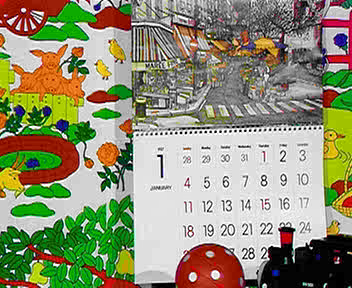

Frame 1:


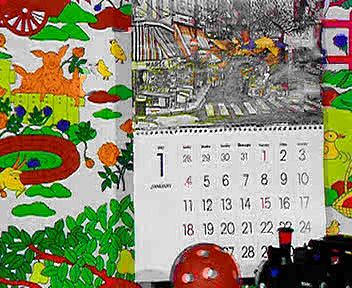

Frame 2:


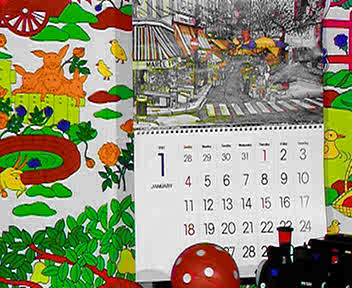

Frame 3:


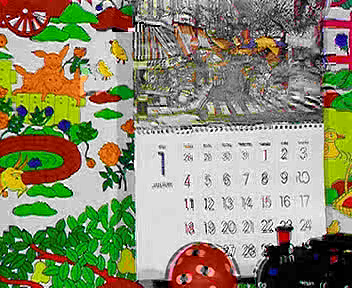

In [13]:
# Visualize reconstructed frames
from IPython.display import display, Image as IPImage
import sys
sys.path.insert(0, '../src')
import platform_utils as pu

# Display first 4 decoded frames
print("=== Reconstructed Frames ===")

for i in range(min(4, 16)):
    frame_path = pu.get_temp_path(f"decoded_{i:04d}.png")
    if os.path.exists(frame_path):
        print(f"Frame {i}:")
        display(IPImage(filename=frame_path, width=352))

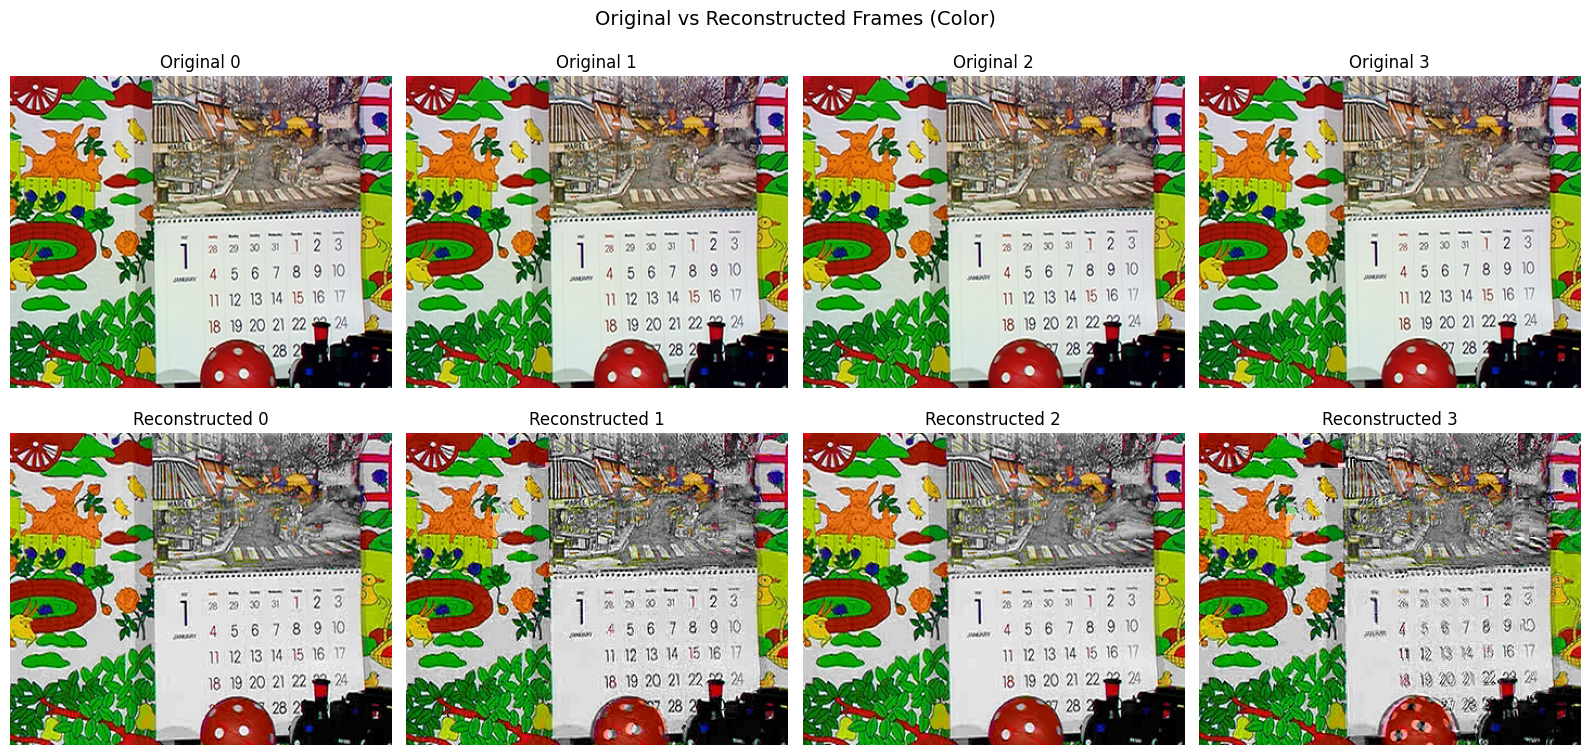

In [14]:
# Compare original vs reconstructed frames (COLOR)
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import sys
sys.path.insert(0, '../src')
import platform_utils as pu

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Original vs Reconstructed Frames (Color)', fontsize=14)

for i in range(4):
    # Original (COLOR - sin convert('L'))
    orig_path = pu.get_temp_path(f"original_{i:04d}.png")
    if os.path.exists(orig_path):
        orig = np.array(Image.open(orig_path))  # Sin .convert('L')
        axes[0, i].imshow(orig)  # Sin cmap='gray'
        axes[0, i].set_title(f'Original {i}')
        axes[0, i].axis('off')
    
    # Reconstructed (COLOR - sin convert('L'))
    dec_path = pu.get_temp_path(f"decoded_{i:04d}.png")
    if os.path.exists(dec_path):
        dec = np.array(Image.open(dec_path))  # Sin .convert('L')
        axes[1, i].imshow(dec)  # Sin cmap='gray'
        axes[1, i].set_title(f'Reconstructed {i}')
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

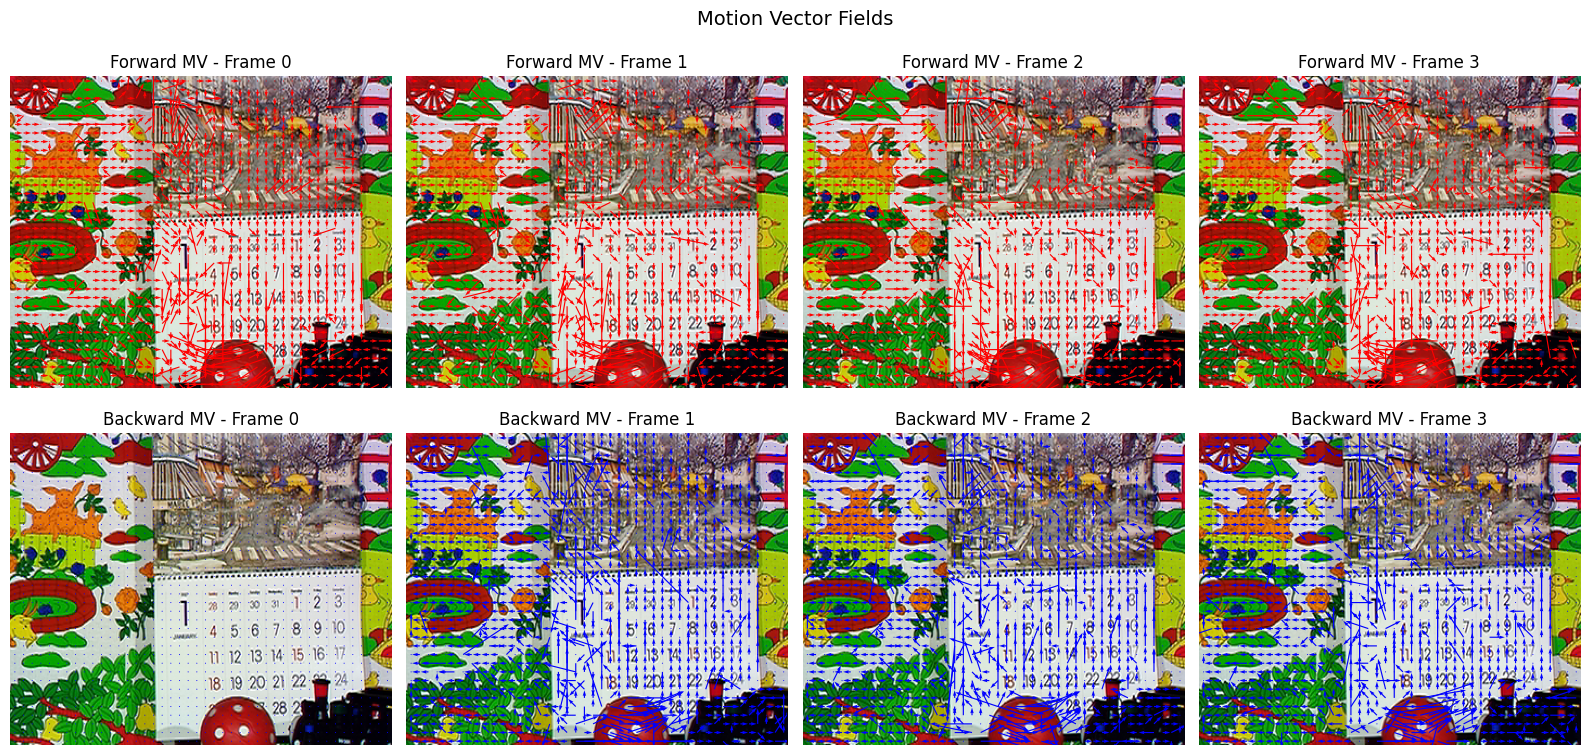

In [15]:
# Visualize motion vector fields
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pickle
import zlib
import os
import sys
sys.path.insert(0, '../src')
import platform_utils as pu

# Read the MCTF stream to get motion vectors
stream_path = pu.get_temp_path("encoded.mctf")

if os.path.exists(stream_path):
    with open(stream_path, 'rb') as f:
        header = pickle.load(f)
        gop_data = pickle.load(f)
    
    # Decompress motion vectors
    mv_forward = np.frombuffer(
        zlib.decompress(gop_data['mv_forward']), 
        dtype=np.float32
    ).reshape(gop_data['mv_forward_shape'])
    
    mv_backward = np.frombuffer(
        zlib.decompress(gop_data['mv_backward']), 
        dtype=np.float32
    ).reshape(gop_data['mv_backward_shape'])
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Motion Vector Fields', fontsize=14)
    
    block_size = header['block_size']
    
    for i in range(min(4, mv_forward.shape[0])):
        # Load original frame as background (COLOR)
        orig_path = pu.get_temp_path(f"original_{i:04d}.png")
        if os.path.exists(orig_path):
            orig = np.array(Image.open(orig_path))  # Color
        else:
            orig = np.zeros((header['height'], header['width'], 3), dtype=np.uint8)
        
        # Forward motion vectors
        mv_fwd = mv_forward[i]
        blocks_h, blocks_w = mv_fwd.shape[:2]
        
        # Create grid for quiver plot
        Y, X = np.mgrid[0:blocks_h, 0:blocks_w]
        X = X * block_size + block_size // 2
        Y = Y * block_size + block_size // 2
        
        U = mv_fwd[:, :, 0]  # dx
        V = mv_fwd[:, :, 1]  # dy
        
        axes[0, i].imshow(orig)  # Color background
        axes[0, i].quiver(X, Y, U, V, color='red', scale=50, width=0.003)
        axes[0, i].set_title(f'Forward MV - Frame {i}')
        axes[0, i].axis('off')
        
        # Backward motion vectors
        mv_bwd = mv_backward[i]
        U_bwd = mv_bwd[:, :, 0]
        V_bwd = mv_bwd[:, :, 1]
        
        axes[1, i].imshow(orig)  # Color background
        axes[1, i].quiver(X, Y, U_bwd, V_bwd, color='blue', scale=50, width=0.003)
        axes[1, i].set_title(f'Backward MV - Frame {i}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Stream not found: {stream_path}")
    print("Run encode first!")